## Objetivo:

O objetivo desta competição é desenvolver um modelo preditor do ELDT (Estimated Landing Time) para voos comerciais com origem e 
destino nos 12 principais aeródromos do Brasil, a saber:

- Brasília (SBBR)
- Confins (SBCF)
- Curitiba (SBCT)
- Florianópolis (SBFL)
- Rio de Janeiro - Galeão (SBGL)
- Guarulhos (SBGR)
- Campinas (SBKP)
- Porto Alegre (SBPA)
- Recife (SBRF)
- Rio de Janeiro - Santos Dumont (SBRJ)
- São Paulo - Congonhas (SBSP)
- Salvador (SBSV)

In [1]:
!pip install xgboost
!pip install git+https://github.com/python-metar/python-metar.git

import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xg


import requests
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from metar import Metar
import re
from sklearn.impute import KNNImputer

random.seed(1)

print(f'tf_version: {tf.__version__}')


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/python-metar/python-metar.git to /tmp/pip-req-build-w0_n9ms6
  Running command git clone --filter=blob:none --quiet https://github.com/python-metar/python-metar.git /tmp/pip-req-build-w0_n9ms6
  Resolved https://github.com/python-metar/python-metar.git to commit a74df97e61f905617f1707641ddddc5ff236050c
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
2023-09-28 14:37:46.624607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 14:37:46.725187: W tensorflow/stream_executor/p

## Funções auxiliares

In [2]:
# Função para carregar os dados da API

def get_data_from_API(base_name, idate, fdate, token='a779d04f85c4bf6cfa586d30aaec57c44e9b7173'):
    ''' base_name (string): nome da base, opcões: bimtra, cat-62, esperas, metaf, metar, satelite, tc-prev, tc-real
        idate (string): data inicial
        fdate (string): data final
        token (string): chave de acesso na API já está defaltada
    ''' 


    url = 'http://montreal.icea.decea.mil.br:5002/api/v1/' + base_name
    params = {
    'token': token,
    'idate': idate,
    'fdate': fdate
}

    headers = {'accept': 'application/json'}

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        base = response.json()
        print(f"Base {base_name} carregada com sucesso!")
        return pd.DataFrame(base)
    else:
        print(f"A solicitação falhou com status code {response.status_code}")

In [3]:
# Função para transformar datetime em int64

def datetime_to_int64(df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S.%f')
    df[column] = (df[column].astype(int) / 10**6) #.astype('datetime64[ms]')
    return df

# Função para transformar int64 em datetime

def int64_to_datetime(data, column=None):
    if column is None:
        # Se 'column' não for especificado, assumimos que 'data' é uma Series
        return data.astype('datetime64[ms]')
    else:
        # Se 'column' for especificado, assumimos que 'data' é um DataFrame
        data[column] = data[column].astype('datetime64[ms]')
        return data

A base de dados BIMTRA possui informações dos movimentos nos aeródromos do Brasil. Assim, é possível encontrar 
dados como hora de decolagem estimada, origem, destino, tempo de voo previsto, etc. Para o problema em questão, 
uma versão resumida do BIMTRA será fornecida, contendo os seguintes campos:

FlightID (Identificador único de um voo)
Origem (Código ICAO do Aeroporto de Origem do voo)
Destino (Código ICAO do Aeroporto de Destino do voo)
Hora_Dep (Data/Hora de Decolagem do voo)
Hora_Arr (Data/Hora de Pouso do voo)

O campo Hora_Arr corresponde ao atributo alvo do desafio proposto, isto é, o modelo desenvolvido por cada equipe 
deverá estimar os valores de Hora_Arr. Tomem cuidado com data leakage, ou seja, construindo modelos com informações do futuro.

In [4]:
# Setar datas para pegar dados da API
data_inicial = "2022-06-01"
data_final = "2023-05-13"

# Carregar o dataset BIMTRA
BIMTRA_df = get_data_from_API('bimtra', data_inicial, data_final)
BIMTRA_df

Base bimtra carregada com sucesso!


,flightid,origem,destino,dt_dep,dt_arr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000
...,...,...,...,...,...
300342,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000
300343,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000
300344,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000
300345,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000


Fenômenos meteorológicos exercem uma forte influência na pontualidade de um voo. Por esse motivo, serão fornecidos dados meteorológicos de 4 fontes:

METAR (Meteorological Aerodrome Report)
Imagens de satélite meteorológico
METAF (Terminal Aerodrome Forecast)

Os dados de Satélite Meteorológico serão disponibilizados em formato de imagem, como ilustrado na figura, em que é possível identificar tempos severos, potenciais precipitações, tendências de movimento de nuvens, etc.

<img src="image-20230927-140445.png" width="50%" align="" />

As bases METAR e METAF apresentam dados de telemetria de estações meteorológicas da região dos aeródromos, como temperatura, velocidade do vento, umidade, etc. Mais informações sobre quais dados existem e como interpretar os dados de METAR e METAF estão disponíveis aqui. Embora a codificação destas informações seja complexa, é possível utilizar bibliotecas python para o parsing. Um exemplo de uma biblioteca com essa funcionalidade está disponível aqui.

A diferença entre as bases METAF e METAR é que a METAR é o valor observado enquanto a METAF apresenta previsões para a próxima hora.

In [5]:
metar_df = get_data_from_API("metar", data_inicial, data_final)
metaf_df = get_data_from_API("metaf", data_inicial, data_final)

Base metar carregada com sucesso!
Base metaf carregada com sucesso!


Complementarmente, serão fornecidos dados de ATFM (Air Traffic Flow Management) que permitem auxiliar na análise comportamental do espaço aéreo, e compreendem:

Esperas em voo
Previsão de Troca de Cabeceira
Histórico de Troca de Cabeceira

A base de dados Esperas contém o histórico de ocorrências de espera em voo por hora e aeródromo. Como temos 12 aeródromos, teremos 12 registros na base de dados por hora, onde cada registro indicará a quantidade de voos em espera para cada aeródromo.

A base de dados Previsão de Troca de Cabeceira traz as previsões por hora de troca de cabeceira nos aeroportos. Os campos dessa base compreendem a hora de referência, a informação de troca de cabeceira (variável booleana) e o aeroporto. Enquanto a base de Histórico de Troca de Cabeceira corresponde às observações de troca de cabeceira, que traz os campos hora de referência, quantidade de trocas de cabeceira nessa hora e o aeroporto.

In [6]:
esperas_df = get_data_from_API('esperas', data_inicial, data_final)
tc_prev_df = get_data_from_API('tc-prev', data_inicial, data_final)
tc_real_df = get_data_from_API('tc-real', data_inicial, data_final)

Base esperas carregada com sucesso!
Base tc-prev carregada com sucesso!
Base tc-real carregada com sucesso!


In [7]:
# Cálculo do ELDT 
# ELDT = (pd.to_datetime(BIMTRA_df.dt_arr) - pd.to_datetime(BIMTRA_df.dt_dep)).dt.total_seconds()
ELDT = BIMTRA_df['dt_arr'] - BIMTRA_df['dt_dep']
BIMTRA_df['eldt'] = ELDT
BIMTRA_df

,flightid,origem,destino,dt_dep,dt_arr,eldt
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000,2463000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000,2152000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000,4613000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000,2581000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000
...,...,...,...,...,...,...
300342,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000
300343,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000
300344,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000
300345,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000


# 1. Tratamento de Dados

## 1.1 Células vazias e duplicadas

In [8]:
# Checagem de células vazias
display(pd.DataFrame(BIMTRA_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', BIMTRA_df.duplicated().sum())
BIMTRA_df_adjusted = BIMTRA_df.drop_duplicates(inplace=False)

,Nº Células Vazias
flightid,0
origem,0
destino,0
dt_dep,0
dt_arr,0
eldt,0


Número de duplicatas:  13312


In [9]:
print('Número de duplicatas após eliminação: ', BIMTRA_df_adjusted.duplicated().sum())

Número de duplicatas após eliminação:  0


In [10]:
# Checagem de células vazias
display(pd.DataFrame(tc_prev_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', tc_prev_df.duplicated().sum())
tc_prev_df_adjusted = tc_prev_df.drop_duplicates(inplace=False)

,Nº Células Vazias
hora,0
troca,0
aero,0


Número de duplicatas:  0


In [11]:
# Checagem de células vazias
display(pd.DataFrame(tc_real_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', tc_real_df.duplicated().sum())
tc_real_df_adjusted = tc_real_df.drop_duplicates(inplace=False)

,Nº Células Vazias
hora,0
nova_cabeceira,0
antiga_cabeceira,0
aero,0


Número de duplicatas:  0


In [12]:
# Checagem de células vazias
display(pd.DataFrame(esperas_df.isnull().sum(), columns=['Nº Células Vazias']))

# Checagem de células duplicadas
print('Número de duplicatas: ', esperas_df.duplicated().sum())
esperas_df_adjusted = esperas_df.drop_duplicates(inplace=False)

,Nº Células Vazias
esperas,0
hora,0
aero,0


Número de duplicatas:  0


## 1.2 Valores negativos

In [13]:
# Máscara booleana das linhas <= 0
mask = BIMTRA_df_adjusted['eldt'] <= 0

print('Número de linhas onde ELDT <= 0: ', BIMTRA_df_adjusted[mask].values.shape[0])
display(BIMTRA_df_adjusted[mask])

# Remove as linhas
BIMTRA_df_adjusted = BIMTRA_df_adjusted[~mask]

Número de linhas onde ELDT <= 0:  362


,flightid,origem,destino,dt_dep,dt_arr,eldt
959,8b3f12d8ed9e058f3376775871eedb0b,SBRF,SBGR,1654155636000,1654154272000,-1364000
1293,aef3f7cf8b6978a497133ea80e0c86fc,SBSP,SBFL,1654190114000,1654187529000,-2585000
1550,310b5374273eb182ca50015a2563ac65,SBRJ,SBSP,1654300104000,1654298716000,-1388000
1619,49d1f882d1db81ea17aa7854b0e5fab9,SBRJ,SBSP,1654300104000,1654216563000,-83541000
1620,8d8998b8f3da5d2367b6b5ce84258ead,SBRJ,SBSP,1654298696000,1654216563000,-82133000
...,...,...,...,...,...,...
292859,681c4e7e7a0710fdea94ca040e5601c5,SBRJ,SBCT,1683286282000,1683285726000,-556000
293000,c53dab3a854660c840f02407bae7b5ad,SBGR,SBCT,1683321682000,1683252992000,-68690000
296362,9920fdcf556e30604a74118aac038de2,SBKP,SBCF,1683666837000,1683660378000,-6459000
297917,476fab74550f6747dc753b167e044a6a,SBRJ,SBFL,1683811190000,1683807345000,-3845000


## 1.3 Alterar colunas e juntar os dados

Vamos arredondar as horas para baixo numa nova coluna para ser usada como referência quando for juntar dataframes diferentes que precisam se identificar pelas horas. Para tal, utilizamos o método floor passando o "H" de horas como parâmetro.

In [14]:
hora_ref = BIMTRA_df_adjusted['dt_dep']# Valores em int64 
hora_ref = int64_to_datetime(hora_ref) # Transformando series em datetime
hora_ref = hora_ref.dt.floor('H') # Aproximando horas para baixo
BIMTRA_df_adjusted['hora_ref'] = hora_ref # Adicionando nova coluna

BIMTRA_df_adjusted['hora_ref']

0        2022-06-01 00:00:00
1        2022-06-01 00:00:00
2        2022-06-01 00:00:00
3        2022-06-01 00:00:00
4        2022-06-01 01:00:00
                 ...        
300342   2023-05-13 12:00:00
300343   2023-05-13 09:00:00
300344   2023-05-13 16:00:00
300345   2023-05-13 05:00:00
300346   2023-05-13 09:00:00
Name: hora_ref, Length: 286673, dtype: datetime64[ns]

### Previsão de troca de cabeceiras

In [15]:
# Previsão de mudança de cabeceiras
display(tc_prev_df.head())

,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR


Mudar os dados da coluna "hora" para datetime. Assim, analisaremos melhor e será mais fácil para arredondar para um horario específico para o merge dos dataframes no futuro. Também vamos adicionar SB antes de todas as células da coluna "aero", para poder ficar igual a base BIMTRA.

In [16]:
tc_real_to_merge = tc_real_df_adjusted.copy()

# Data e hora
tc_real_to_merge = int64_to_datetime(tc_real_to_merge, 'hora')
tc_real_to_merge.rename(columns={'hora': 'hora_tcr'}, inplace=True)

tc_real_to_merge['hora_tcr'] = tc_real_to_merge['hora_tcr'].dt.floor('H')
print("Duplicatas após aproximação das horas:", tc_real_to_merge.duplicated().sum())

# Adicionar SB antes dos nomes na coluna aero 
tc_real_to_merge['destino'] =  'SB' + tc_real_to_merge['aero'].str[0:2]
tc_real_to_merge.drop(['aero'], axis=1, inplace=True)

# Dropar colunas "nova_cabeeceira" e "antiga_cabeceira"
tc_real_to_merge.drop(['nova_cabeceira', 'antiga_cabeceira'], axis=1, inplace=True)

print("Duplicatas após eliminação de colunas das cabeceiras:", tc_real_to_merge.duplicated().sum())

# Remover linhas duplicadas
tc_real_to_merge = tc_real_to_merge.drop_duplicates(inplace=False)

# Adicionar coluna de 1's para poder identificar quais vôos obtiveram a troca de cabeceiras após merge
tc_real_to_merge['troca_efetivada'] = 1

tc_real_to_merge

Duplicatas após aproximação das horas: 4752
Duplicatas após eliminação de colunas das cabeceiras: 13543


,hora_tcr,destino,troca_efetivada
0,2022-06-01 14:00:00,SBFL,1
1,2022-06-01 18:00:00,SBRF,1
2,2022-06-01 19:00:00,SBCF,1
3,2022-06-01 19:00:00,SBGL,1
5,2022-06-01 19:00:00,SBFL,1
...,...,...,...
33424,2023-05-13 20:00:00,SBGL,1
33425,2023-05-13 15:00:00,SBRJ,1
33427,2023-05-13 22:00:00,SBSP,1
33428,2023-05-13 15:00:00,SBCT,1


### Troca de cabeceiras observadas

In [17]:
# Mudança de cabeceiras observadas
display(tc_real_df_adjusted)

,hora,nova_cabeceira,antiga_cabeceira,aero
0,1654092843000,32,03,FL
1,1654109470000,18,12,RF
2,1654110745000,16,13,CF
3,1654110758000,15,26,GL
4,1654110777000,15,26,GL
...,...,...,...,...
33426,1683991948000,14,08,FL
33427,1684015596000,17R,12,SP
33428,1683992504000,15,26,CT
33429,1684017668000,17R,12,SP


In [18]:
tc_prev_to_merge = tc_prev_df_adjusted.copy()

# Data e hora

tc_prev_to_merge

int64_to_datetime(tc_prev_to_merge, 'hora')
tc_prev_to_merge.rename(columns={'hora': 'hora_tcp'}, inplace=True)

# Adicionar SB antes dos nomes na coluna aero 
tc_prev_to_merge['aero'] =  'SB' + tc_prev_to_merge['aero']
tc_prev_to_merge.rename(columns={'aero': 'destino'}, inplace=True)

tc_prev_to_merge

,hora_tcp,troca,destino
0,2022-06-01 00:00:00,0,SBBR
1,2022-06-01 01:00:00,0,SBBR
2,2022-06-01 02:00:00,0,SBBR
3,2022-06-01 03:00:00,0,SBBR
4,2022-06-01 04:00:00,0,SBBR
...,...,...,...
99931,2023-05-13 19:00:00,0,SBSV
99932,2023-05-13 20:00:00,0,SBSV
99933,2023-05-13 21:00:00,0,SBSV
99934,2023-05-13 22:00:00,0,SBSV


In [19]:
BIMTRA_tc = BIMTRA_df_adjusted.copy()

# Criar coluna para ser usada para merge dos dataframes
BIMTRA_tc['hora_tcp'] = BIMTRA_tc['hora_ref'] + pd.Timedelta(hours=1)

BIMTRA_tc = pd.merge(BIMTRA_tc, tc_prev_to_merge, on=['destino', 'hora_tcp'], how='left')

display(BIMTRA_tc)

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000,2463000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000,2152000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000,4613000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000,2581000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0
...,...,...,...,...,...,...,...,...,...
286668,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0
286669,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0
286670,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0
286671,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0


Vamos juntar os dados da previsão da troca de cabeceiras com os dados BIMTRA, através hora após a decolagem e no aeroporto de destino especifico

Os números das cabeceiras variam de 01 a 36, sempre com dois dígitos. Quando a cabeceira tem o número 27, significa que durante os pousos e decolagens a bússola marca 270°. No Santos Dumont, no Rio de Janeiro, os números são 02 e 20, enquanto Congonhas usa 17 e 35. Quando há duas pistas paralelas em um mesmo aeroporto, as cabeceiras têm os mesmos números, já que estão na mesma direção. Por conta disso, ganham as letras L ou R para diferenciar as pistas da esquerda (left) e da direita (right) na visão do piloto. Se houver três pistas paralelas, a central ganha a letra C (center).

Se, durante o voo, as condições meteorológicas ou outros fatores mudarem de tal forma que seja mais seguro ou eficiente usar uma pista de pouso diferente da planejada inicialmente, a torre de controle e a tripulação de voo podem tomar a decisão de trocar de cabeceira. Isso geralmente ocorre antes da aeronave se aproximar do aeroporto.

In [20]:
BIMTRA_cabeceiras = BIMTRA_tc.copy()

BIMTRA_cabeceiras['hora_tcr'] = pd.to_datetime(BIMTRA_tc['dt_dep'], unit='ms')

BIMTRA_cabeceiras['hora_tcr'] = BIMTRA_cabeceiras['hora_tcr'].dt.floor('H')

# Realizar a concatenação dos dataframes
BIMTRA_cabeceiras = pd.merge(BIMTRA_cabeceiras, tc_real_to_merge, on=['destino', 'hora_tcr'], how='left')

# Preenchar valores nan que nao tiveram match no merge, logo não tiveram troca de cabeceira observada
BIMTRA_cabeceiras['troca_efetivada'].fillna(0, inplace=True)

BIMTRA_cabeceiras

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,troca_efetivada
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000,2463000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000,2152000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000,4613000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000,2581000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
286668,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,0.0
286669,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,0.0
286670,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,0.0
286671,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,0.0


In [21]:
num_trocas_observ = BIMTRA_cabeceiras['troca_efetivada'].count()
num_voos_diferentes = BIMTRA_cabeceiras['flightid'].nunique()
trocas_prev = BIMTRA_cabeceiras[BIMTRA_cabeceiras['troca']==1].count() 
num_trocas_prev = trocas_prev.iloc[0]
trocas_acertadas = len(BIMTRA_cabeceiras[(BIMTRA_cabeceiras['troca'] == 1) & (BIMTRA_cabeceiras['troca_efetivada'] == 1)])

print("Numero de voos com trocas observadas:", num_trocas_observ)
print("Numero de voos com trocas previstas:", num_trocas_prev)
print("Numero de voos com trocas previstas corretamente:", trocas_acertadas)

print("Numero de voos diferentes:", num_voos_diferentes)
print("Numero de voos duplicados:", BIMTRA_cabeceiras.flightid.duplicated().sum())

Numero de voos com trocas observadas: 286673
Numero de voos com trocas previstas: 85115
Numero de voos com trocas previstas corretamente: 22823
Numero de voos diferentes: 286673
Numero de voos duplicados: 0


### Esperas

In [22]:
esperas_df_adjusted.head()

,esperas,hora,aero
0,0,1654041600000,SBBR
1,0,1654045200000,SBBR
2,0,1654048800000,SBBR
3,0,1654052400000,SBBR
4,0,1654056000000,SBBR


In [23]:
esperas_to_merge = esperas_df_adjusted.copy()

# Data e hora
int64_to_datetime(esperas_to_merge, 'hora')
esperas_to_merge.rename(columns={'hora': 'hora_esperas'}, inplace=True)

esperas_to_merge.rename(columns={'aero': 'destino'}, inplace=True)
esperas_to_merge

,esperas,hora_esperas,destino
0,0,2022-06-01 00:00:00,SBBR
1,0,2022-06-01 01:00:00,SBBR
2,0,2022-06-01 02:00:00,SBBR
3,0,2022-06-01 03:00:00,SBBR
4,0,2022-06-01 04:00:00,SBBR
...,...,...,...
99931,0,2023-05-13 19:00:00,SBSV
99932,0,2023-05-13 20:00:00,SBSV
99933,0,2023-05-13 21:00:00,SBSV
99934,0,2023-05-13 22:00:00,SBSV


Fazer alterações similares as feitas ao dataset das previsões de trocas de cabeceiras. Entretando, este tem as trocas que realmente aconteceram (obeservadas). Ele possui colunas com informação sobre quais cabeceiras serão alteradas, as quais não iremos precisar para nosso modelo. Duplicatas irão surgir pois temos linhas com destino e hora repetidas por conta de diferentes cabeceiras trocadas para um determinado horário num determinado aeroporto. Assim, devemos excluí-las.

Juntar os dados da previsão das trocas de cabeceiras observadas com os demais

In [24]:
BIMTRA_cabeceiras_esperas = BIMTRA_cabeceiras.copy()

BIMTRA_cabeceiras_esperas['hora_esperas'] = BIMTRA_cabeceiras_esperas['hora_ref'] - pd.Timedelta(hours=1)

BIMTRA_cabeceiras_esperas = pd.merge(BIMTRA_cabeceiras_esperas, esperas_to_merge, on=['destino', 'hora_esperas'], how='left')
BIMTRA_cabeceiras_esperas

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,troca_efetivada,hora_esperas,esperas
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000,2463000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000,2152000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000,4613000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000,2581000,2022-06-01 00:00:00,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,2022-05-31 23:00:00,NaN
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286668,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,0.0,2023-05-13 11:00:00,0.0
286669,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,0.0,2023-05-13 08:00:00,0.0
286670,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,0.0,2023-05-13 15:00:00,0.0
286671,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,0.0,2023-05-13 04:00:00,0.0


Células vazias foram geradas pois estamos pegando dados de 1 hora antes de nossa hora_ref, logo, teremos horas de um dia anterior em que não temos esses dados do request. Então iremos retirar essas linhas.

In [25]:
# Checagem de células vazias
display(pd.DataFrame(BIMTRA_cabeceiras_esperas.isnull().sum(), columns=['Nº Células Vazias']))
BIMTRA_cabeceiras_esperas = BIMTRA_cabeceiras_esperas.dropna()


,Nº Células Vazias
flightid,0
origem,0
destino,0
dt_dep,0
dt_arr,0
eldt,0
hora_ref,0
hora_tcp,0
troca,2
hora_tcr,0


### Metar

METAR (Meteorological Aerodrome Report)

As bases METAR e METAF apresentam dados de telemetria de estações meteorológicas da região dos aeródromos, como temperatura, velocidade do vento, umidade, etc. A diferença entre as bases METAF e METAR é que a METAR é o valor observado enquanto a METAF apresenta previsões para a próxima hora.

In [26]:
display(metar_df)

,hora,metar,aero
0,1654041600000,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018=,SBBR
1,1654045200000,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019=,SBBR
2,1654048800000,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019=,SBBR
3,1654052400000,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019=,SBBR
4,1654056000000,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018=,SBBR
...,...,...,...
106739,1684004400000,METAR SBSV 131900Z 16009KT 9999 BKN020 FEW021T...,SBSV
106740,1684008000000,METAR SBSV 132000Z 13007KT 9999 BKN020 29/24 Q...,SBSV
106741,1684011600000,METAR SBSV 132100Z 12005KT 9999 SCT020 FEW025T...,SBSV
106742,1684015200000,METAR SBSV 132200Z 11006KT 9999 SCT020 FEW025T...,SBSV


A biblioteca Metar será utilizada para tratar os dados meteorologicos. A função seguinte pega cada valor de uma string de dados e extrai características relevantes.

In [27]:
#  method:
#
#    Attribute          Comments [data type]
#    ----------------   ------------------------------------------
#    code               original METAR code [string]
#    type               METAR (routine) or SPECI (special) [string]
#    mod                AUTO (automatic) or COR (corrected) [string]
#    station_id         4-character ICAO station code [string]
#    time               observation time [datetime]
#    cycle              observation cycle (0-23) [int]
#    wind_dir           wind direction [direction]
#    wind_speed         wind speed [speed]
#    wind_gust          wind gust speed [speed]
#    wind_dir_from      beginning of range for win dir [direction]
#    wind_dir_to        end of range for wind dir [direction]
#    vis                visibility [distance]
#    vis_dir            visibility direction [direction]
#    max_vis            visibility [distance]
#    max_vis_dir        visibility direction [direction]
#    temp               temperature (C) [temperature]
#    dewpt              dew point (C) [temperature]
#    press              barometric pressure [pressure]
#    runway             runway visibility [list of tuples...]
#                          name [string]
#                          low  [distance]
#                          high [distance]
#    weather            present weather [list of tuples...]
#                          intensity     [string]
#                          description   [string]
#                          precipitation [string]
#                          obscuration   [string]
#                          other         [string]
#    recent             recent weather [list of tuples...]
#    sky                sky conditions [list of tuples...]
#                          cover   [string]
#                          height  [distance]
#                          cloud   [string]
#    windshear          runways w/ wind shear [list of strings]
#
#    press_sea_level    sea-level pressure [pressure]
#    wind_speed_peak    peak wind speed in last hour [speed]
#    wind_dir_peak      direction of peak wind speed in last hour [direction]
#    max_temp_6hr       max temp in last 6 hours [temperature]
#    min_temp_6hr       min temp in last 6 hours [temperature]
#    max_temp_24hr      max temp in last 24 hours [temperature]
#    min_temp_24hr      min temp in last 24 hours [temperature]
#    precip_1hr         precipitation over the last hour [precipitation]
#    precip_3hr         precipitation over the last 3 hours [precipitation]
#    precip_6hr         precipitation over the last 6 hours [precipitation]
#    precip_24hr        precipitation over the last 24 hours [precipitation]
#
#    _remarks           remarks [list of strings]
#    _unparsed_groups   unparsed groups [list of strings]
#    _unparsed_remarks  unparsed remarks [list of strings]

#
#  The metar.Datatypes classes (temperature, pressure, precipitation,
#  speed, direction) describe an observation and its units.  They provide
#  value() and string() methods to that return numerical and string
#  representations of the data in any of a number of supported units.
#
#  (You're going to have to study the source code for more details,
#  like the available methods and supported unit conversions for the
#  metar.Datatypes objects, etc..)

#  In particular, look at the Metar.string()
#  method, and the functions it calls.
#

In [28]:
from __future__ import print_function

def treat_metar_data(data):
    # data_example = "METAR SBSP 291400Z 15011KT 120V180 9999 SCT009 BKN013 BKN020 17/14 Q1024="
    print("-----------------------------------------------------------------------")
    print("METAR: ", data)
    print("-----------------------------------------------------------------------")

    try:
        # Inicialize um objeto Metar com o relatório codificado
        obs = Metar.Metar(data)

        # Inicialize um dicionário para armazenar as variáveis
        metar_data = {}

        # Armazene as variáveis no dicionário
        metar_data["aeroporto"] = obs.station_id

        if obs.type:
            metar_data["report_type"] = obs.report_type()

        if obs.time:
            metar_data["time"] = obs.time.ctime()

        if obs.temp:
            metar_data["temperature"] = obs.temp.string("C")

        if obs.dewpt:
            metar_data["dew_point"] = obs.dewpt.string("C")

        if obs.wind_speed:
            metar_data["wind"] = obs.wind()

        if obs.wind_speed_peak:
            metar_data["peak_wind"] = obs.peak_wind()

        if obs.vis:
            metar_data["visibility"] = obs.visibility()

        if obs.runway:
            metar_data["visual_range"] = obs.runway_visual_range()

        if obs.press:
            metar_data["pressure"] = obs.press.string("mb")
    
        if obs.precip_1hr:
            metar_data["precipitation"] = obs.precip_1hr.string("in")

        metar_data["weather"] = obs.present_weather()
        metar_data["sky"] = obs.sky_conditions("\n     ")

        if obs._remarks:
            metar_data["remarks"] = obs.remarks("\n- ")

        print(metar_data["time"])
        
    except Exception as e:
        # Em caso de exceção, você pode tratar o erro aqui
        print(f"Erro ao processar METAR: {e}")
        metar_data = {}  # Retornar um dicionário vazio

    return metar_data

<img src="image-20230920-133438.png" width="" align="" />

Exemplo do retorno da função acima.

In [29]:
treat_metar_data(metar_df['metar'][0])

-----------------------------------------------------------------------
METAR:  METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018=
-----------------------------------------------------------------------
Fri Sep  1 00:00:00 2023


{'aeroporto': 'SBBR',
 'report_type': 'routine report (automatic report)',
 'time': 'Fri Sep  1 00:00:00 2023',
 'temperature': '21.0 C',
 'dew_point': '8.0 C',
 'wind': 'ENE at 2 knots',
 'visibility': '10000 meters',
 'pressure': '1018.0 mb',
 'weather': '',
 'sky': ''}

Função para pegar cada linha do argumento passado e retornar um nomo df com os dados tratados com a função treat_metar_data().

In [30]:
def get_all_metar_data(metar_data):
    metar_columns = pd.DataFrame(columns=['aeroporto', 'report_type', 'time', 'temperature', 'dew_point', 'visibility', 'wind', 'visual_range', 'pressure', 'weather', 'sky'])
    erro = []
    # Itere sobre os dados da coluna 'metar' e aplique a função 'treat_metar_data'
    for metar in metar_data:
        try:
            if not pd.isna(metar):
                # Dicionário 'met'
                metar_dict = treat_metar_data(metar)
                
                #  em uma linha do DataFrame 'result_df'
                metar_columns = metar_columns.append(metar_dict, ignore_index=True)
            else:
                # Se metar for NaN, insira valores nulos nas colunas correspondentes
                metar_columns = metar_columns.append(pd.Series(), ignore_index=True)
        except Exception as e:
            print(f"Erro ao processar METAR: {e}")
            erro.append(metar)
            metar
            continue  # Skip this METAR and continue processing the next one

    print("Erros: " + str(len(erro)))
    print(erro)
    return metar_columns


Transformar a coluna metaf em dados que possamos entender com a função get_all_metar_data()

In [31]:
metar_df_adjusted = metar_df.copy()

metar_df_adjusted = int64_to_datetime(metar_df_adjusted, 'hora')

#metar_columns = get_all_metar_data(metar_df_adjusted['metar'])

metar_columns = pd.read_csv('metar_columns.csv', index_col=None)
if "Unnamed: 0" in metar_columns.columns:
    metar_columns = metar_columns.drop(columns=["Unnamed: 0"])

metar_columns

,aeroporto,dew_point,pressure,report_type,sky,temperature,time,visibility,weather,wind,visual_range
0,SBBR,8.0 C,1018.0 mb,routine report (automatic report),NaN,21.0 C,Fri Sep 1 00:00:00 2023,10000 meters,NaN,ENE at 2 knots,NaN
1,SBBR,9.0 C,1019.0 mb,"routine report, cycle 1 (automatic report)",NaN,20.0 C,Fri Sep 1 01:00:00 2023,10000 meters,NaN,E at 2 knots,NaN
2,SBBR,9.0 C,1019.0 mb,"routine report, cycle 2 (automatic report)",NaN,16.0 C,Fri Sep 1 02:00:00 2023,10000 meters,NaN,calm,NaN
3,SBBR,9.0 C,1019.0 mb,"routine report, cycle 3 (automatic report)",NaN,16.0 C,Fri Sep 1 03:00:00 2023,10000 meters,NaN,W at 2 knots,NaN
4,SBBR,9.0 C,1018.0 mb,"routine report, cycle 4 (automatic report)",NaN,14.0 C,Fri Sep 1 04:00:00 2023,10000 meters,NaN,calm,NaN
...,...,...,...,...,...,...,...,...,...,...,...
106739,SBSV,24.0 C,1013.0 mb,"routine report, cycle 19 (automatic report)",broken clouds at 2000 feet\n a few towerin...,29.0 C,Wed Sep 13 19:00:00 2023,greater than 10000 meters,NaN,SSE at 9 knots,NaN
106740,SBSV,24.0 C,1013.0 mb,"routine report, cycle 20 (automatic report)",broken clouds at 2000 feet,29.0 C,Wed Sep 13 20:00:00 2023,greater than 10000 meters,NaN,SE at 7 knots,NaN
106741,SBSV,24.0 C,1014.0 mb,"routine report, cycle 21 (automatic report)",scattered clouds at 2000 feet\n a few towe...,28.0 C,Wed Sep 13 21:00:00 2023,greater than 10000 meters,NaN,ESE at 5 knots,NaN
106742,SBSV,24.0 C,1014.0 mb,"routine report, cycle 22 (automatic report)",scattered clouds at 2000 feet\n a few towe...,28.0 C,Wed Sep 13 22:00:00 2023,greater than 10000 meters,NaN,ESE at 6 knots,NaN


In [32]:
# metar_columns.to_csv('metar_columns.csv') # salvando para nao ter q rodar tudo de novo

Podemos ver aqui todos os casos unicos de determinadas colunas em string.

In [33]:
metar_columns['weather'].unique()

array([nan, 'patches of fog', 'haze',
       'nearby showers; nearby thunderstorm', 'thunderstorm with rain',
       'light thunderstorm with rain',
       'light thunderstorm with rain; mist',
       'light rain; nearby thunderstorm', 'light rain showers',
       'nearby thunderstorm', 'light rain', 'nearby showers',
       'thunderstorm', 'rain showers', 'rain',
       'thunderstorm; nearby showers', 'heavy thunderstorm with rain',
       'mist', 'drizzle; mist', 'light drizzle',
       'rain showers; thunderstorm', 'rain showers; nearby thunderstorm',
       'light rain showers; thunderstorm', 'thunderstorm with hail',
       'rain; nearby thunderstorm',
       'light rain showers; nearby thunderstorm',
       'light rain; nearby showers', 'rain showers; mist',
       'light drizzle; mist', 'heavy rain', 'light rain; mist',
       'rain; mist', 'heavy thunderstorm with hail and rain',
       'shallow fog', 'partial fog', 'smoke', 'fog',
       'mist; patches of fog', 'light rain; pa

In [34]:
metar_columns['visibility'].unique()

array(['10000 meters', 'greater than 10000 meters',
       '8000 meters; 2000 meters to E', '5000 meters', '7000 meters',
       '9000 meters', '8000 meters', '1000 meters',
       'greater than 10000 meters; 2000 meters to NE',
       'greater than 10000 meters; 3000 meters to NE', '6000 meters',
       '8000 meters; 3000 meters to NE', '8000 meters; 3000 meters to E',
       '5000 meters; 2100 meters to E', '9000 meters; 4000 meters to E',
       '4000 meters', '6000 meters; 2500 meters to E', '3000 meters',
       '8000 meters; 3000 meters to S',
       'greater than 10000 meters; 2000 meters to E',
       'greater than 10000 meters; 4000 meters to S',
       'greater than 10000 meters; 3700 meters to E', '2000 meters',
       '9000 meters; 3000 meters to E', '400 meters',
       '9000 meters; 4000 meters to W', '500 meters',
       '8000 meters; 2000 meters to NE', '50 meters',
       '8000 meters; 3000 meters to SW', '2000 meters; 500 meters to E',
       '600 meters', '900 meters

In [35]:
print(metar_columns['wind'])

0         ENE at 2 knots
1           E at 2 knots
2                   calm
3           W at 2 knots
4                   calm
               ...      
106739    SSE at 9 knots
106740     SE at 7 knots
106741    ESE at 5 knots
106742    ESE at 6 knots
106743    ESE at 9 knots
Name: wind, Length: 106744, dtype: object


Verificando nan values. Temos alguns casos em que não foi possível pegar os dados do metar de algumas variáveis. Talvez pela disponibilização dos dados não ter sido 100% correta em determinadas linhas e por isso a biblioteca utilizada não soube tratá-los. Podemos preenche-los com KNN.

In [79]:
null_values = metar_columns.copy()
null_values = null_values.drop(columns=["weather", "visual_range"])
null_values = null_values.isnull()

# Iterate through the DataFrame and print the values where it's True
for column in null_values.columns:
    print(f"Null values in {column}:")
    for index, value in null_values[column].items():
        if value:
            print(f"Row {index}: {metar_columns.at[index, column]}")

Row 94478: nan
Row 94479: nan
Row 94480: nan
Row 94481: nan
Row 94482: nan
Row 94483: nan
Row 94484: nan
Row 94485: nan
Row 94486: nan
Row 94487: nan
Row 94488: nan
Row 94501: nan
Row 94508: nan
Row 94512: nan
Row 94513: nan
Row 94514: nan
Row 94549: nan
Row 94550: nan
Row 94553: nan
Row 94554: nan
Row 94570: nan
Row 94571: nan
Row 94572: nan
Row 94573: nan
Row 94591: nan
Row 94595: nan
Row 94602: nan
Row 94628: nan
Row 94634: nan
Row 94635: nan
Row 94636: nan
Row 94637: nan
Row 94654: nan
Row 94655: nan
Row 94656: nan
Row 94657: nan
Row 94681: nan
Row 94682: nan
Row 94683: nan
Row 94684: nan
Row 94685: nan
Row 94687: nan
Row 94688: nan
Row 94707: nan
Row 94708: nan
Row 94711: nan
Row 94712: nan
Row 94713: nan
Row 94714: nan
Row 94715: nan
Row 94716: nan
Row 94717: nan
Row 94718: nan
Row 94719: nan
Row 94720: nan
Row 94721: nan
Row 94737: nan
Row 94738: nan
Row 94739: nan
Row 94747: nan
Row 94771: nan
Row 94773: nan
Row 94782: nan
Row 94783: nan
Row 94784: nan
Row 94785: nan
Row 94792:

A sequência de funções tem em vista tratar os dados meteorológicos e serão utilizadas tanto para o metar quando para o metaf. A estratégia é encodar a chuva e a tempestade da coluna 'weather' baseado na intensidade das mesmas. Vamos pegar também o primeiro valor numérico observado em visibilidade e utiliza-lo como parâmetro para treinar o modelo. A mesma ideia será aplicada para a coluna 'wind'. Iremos pegar a primeira velocidade como parâmetro e ignorar as outras devido a complexidade e pouco benefício de saber a velocidade em determinadas direções, já que, inicialmente, não temos como prever em que direção determinado vôo estará viajando para comparar o impacto da direção do vento.

In [37]:
def KNN_missing_values(df, columns_to_impute, n_neighbors=5):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Subset the DataFrame to include only the columns to be imputed
    df_subset = df_copy[columns_to_impute]
    
    # Create a KNNImputer with a specific value for K (n_neighbors)
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    
    # Apply the imputer to the subset of the DataFrame
    df_subset_imputed = pd.DataFrame(knn_imputer.fit_transform(df_subset), columns=columns_to_impute)
    
    # Replace the original columns with the imputed values
    df_copy[columns_to_impute] = df_subset_imputed
    
    return df_copy


def encode_rain_intensity(weather):
    if isinstance(weather, str):  # Verifique se é uma string válida
        if "heavy rain" in weather:
            return 3
        elif "light rain" in weather:
            return 1
        elif "rain" in weather:
            return 2
    return 0


def encode_thunderstorm_intensity(weather):
    if isinstance(weather, str): 
        if "heavy thunderstorm with hail and rain" in weather:
            return 5
        elif "heavy thunderstorm" in weather:
            return 4
        elif "light thunderstorm" in weather:
            return 2
        elif "nearby thunderstorm" in weather:
            return 1
        elif "thunderstorm" in weather:
            return 3
    return 0


def visibility_to_numeric(visibility_str):
    if isinstance(visibility_str, str):  # Verifica se é uma string
        # Regular expression pattern to match the first numeric value in the visibility string
        pattern = r'(\d+) meters'
        match = re.search(pattern, visibility_str)

        if match:
            # Extract the first numeric part of the visibility string
            numeric_value = int(match.group(1))
            
            # Handle the "greater than" case
            if 'greater than' in visibility_str:
                numeric_value += 2000  # Increment to make it different from the exact value
            
            return numeric_value
    return None  # Retorna -1 se não for uma string válida ou se não encontrar um valor numérico


def wind_to_numeric(wind_str):
    if isinstance(wind_str, str):  # Verifica se é uma string
        # Verifica se a string é "calm" e retorna 0
        if wind_str.strip().lower() == "calm":
            return 0
        else:
            # Usando expressão regular para encontrar o número da velocidade do vento
            pattern = r'(\d+) knots'
            match = re.search(pattern, wind_str)
            
            if match:
                return int(match.group(1))  # Retorna o valor da velocidade do vento como um inteiro
    return None  # Retorna None se não for uma string válida ou se não encontrar um valor de velocidade do vento


def get_columns_metar(metar_to_merge, fill_missing_values=False):
    # Removendo colunas desnecessárias
    metar_to_merge.drop(columns=['report_type', 'time', 'visual_range', 'sky', 'aeroporto'], inplace=True)

    # Pegando valores numéricos sem unidades
    metar_to_merge['temperature'] = metar_to_merge['temperature'].str.rstrip(' C').astype(float)
    metar_to_merge['dew_point'] = metar_to_merge['dew_point'].str.rstrip(' C').astype(float)
    metar_to_merge['pressure'] = metar_to_merge['pressure'].str.rstrip(' mb').astype(float)

    # Transformar os dados sobre o vento em numéricos
    numeric_wind_data = [wind_to_numeric(wind) for wind in metar_to_merge['wind']]
    metar_to_merge['wind'] = numeric_wind_data

    # Transformar dados de visibilidade em numéricos
    numeric_visibility_data = [visibility_to_numeric(vis) for vis in metar_to_merge['visibility']]
    metar_to_merge['visibility'] = numeric_visibility_data

    # Encodar casos de chuva e tempestade baseado em suas intensidades
    metar_to_merge['rain'] = metar_to_merge['weather'].apply(encode_rain_intensity)
    metar_to_merge['thunderstorm'] = metar_to_merge['weather'].apply(encode_thunderstorm_intensity)
    metar_to_merge.drop(columns=['weather'], inplace=True)

    # Preencher valores numérico nulos se desejado com algorítmo k-nearest neighbor
    if fill_missing_values == True:
        columns_missing_values = ['temperature', 'dew_point', 'pressure', 'visibility', 'wind']
        metar_to_merge = KNN_missing_values(metar_to_merge, columns_missing_values)

    # Interpolar valores nan
    # metar_to_merge['temperature'] = metar_to_merge['temperature'].interpolate()
    # metar_to_merge['dew_point'] = metar_to_merge['dew_point'].interpolate()
    # metar_to_merge['pressure'] = metar_to_merge['pressure'].interpolate()
    # metar_to_merge['visibility'] = metar_to_merge['visibility'].interpolate()
    # metar_to_merge['wind'] = metar_to_merge['wind'].interpolate()

    return metar_to_merge

Criar df para realizar o merge com os outros dados baseado no aeroporto e no horário

In [38]:
metar_to_merge = metar_columns.copy()
#metar_to_merge = metar_to_merge.dropna(subset=['dew_point', 'pressure', 'sky', 'visibility', 'wind'])
metar_to_merge = get_columns_metar(metar_to_merge, fill_missing_values=True)

metar_to_merge = pd.concat([metar_df_adjusted, metar_to_merge], axis=1)
metar_to_merge.drop(columns=['metar'], inplace = True)
metar_to_merge.rename(columns={"aero": "origem", "hora": "hora_ref"}, inplace=True)

metar_to_merge

,hora_ref,origem,dew_point,pressure,temperature,visibility,wind,rain,thunderstorm
0,2022-06-01 00:00:00,SBBR,8.0,1018.0,21.0,10000.0,2.0,0,0
1,2022-06-01 01:00:00,SBBR,9.0,1019.0,20.0,10000.0,2.0,0,0
2,2022-06-01 02:00:00,SBBR,9.0,1019.0,16.0,10000.0,0.0,0,0
3,2022-06-01 03:00:00,SBBR,9.0,1019.0,16.0,10000.0,2.0,0,0
4,2022-06-01 04:00:00,SBBR,9.0,1018.0,14.0,10000.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
106739,2023-05-13 19:00:00,SBSV,24.0,1013.0,29.0,12000.0,9.0,0,0
106740,2023-05-13 20:00:00,SBSV,24.0,1013.0,29.0,12000.0,7.0,0,0
106741,2023-05-13 21:00:00,SBSV,24.0,1014.0,28.0,12000.0,5.0,0,0
106742,2023-05-13 22:00:00,SBSV,24.0,1014.0,28.0,12000.0,6.0,0,0


Após tratamento de dados não temos mais valores nulos

In [39]:
null_values = metar_to_merge.copy()
null_values = null_values.isnull()

# Iterate through the DataFrame and print the values where it's True
for column in null_values.columns:
    print(f"Null values in {column}:")
    for index, value in null_values[column].items():
        if value:
            print(f"Row {index}: {metar_to_merge.at[index, column]}")

Null values in hora_ref:
Null values in origem:
Null values in dew_point:
Null values in pressure:
Null values in temperature:
Null values in visibility:
Null values in wind:
Null values in rain:
Null values in thunderstorm:


In [40]:
BIMTRA_cab_esp_metar = pd.merge(BIMTRA_cabeceiras_esperas, metar_to_merge, on=['origem', 'hora_ref'], how='left')

BIMTRA_cab_esp_metar

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,troca_efetivada,hora_esperas,esperas,dew_point,pressure,temperature,visibility,wind,rain,thunderstorm
0,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,14.0,1018.0,21.0,10000.0,5.0,0.0,0.0
1,052050016538ab736a254313ef009a6b,SBRJ,SBCF,1654075204000,1654078210000,3006000,2022-06-01 09:00:00,2022-06-01 10:00:00,0.0,2022-06-01 09:00:00,0.0,2022-06-01 08:00:00,0.0,21.0,1015.0,22.0,12000.0,4.0,0.0,0.0
2,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,1654046445000,1654051465000,5020000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1020.0,16.0,12000.0,3.0,0.0,0.0
3,2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,1654046039000,1654051301000,5262000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1020.0,16.0,12000.0,3.0,0.0,0.0
4,f738e67220fcd688fed028a6389891e2,SBKP,SBPA,1654046798000,1654051882000,5084000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,0.0,2022-06-01 00:00:00,0.0,15.0,1018.0,17.0,10000.0,14.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286619,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,0.0,2023-05-13 11:00:00,0.0,14.0,1022.0,21.0,10000.0,4.0,0.0,0.0
286620,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,0.0,2023-05-13 08:00:00,0.0,14.0,1020.0,16.0,10000.0,0.0,0.0,0.0
286621,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,0.0,2023-05-13 15:00:00,0.0,14.0,1018.0,26.0,12000.0,6.0,0.0,0.0
286622,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,0.0,2023-05-13 04:00:00,0.0,25.0,1013.0,26.0,12000.0,3.0,0.0,0.0


### Metaf

METAF (Terminal Aerodrome Forecast)

As bases METAR e METAF apresentam dados de telemetria de estações meteorológicas da região dos aeródromos, como temperatura, velocidade do vento, umidade, etc. A diferença entre as bases METAF e METAR é que a METAR é o valor observado enquanto a METAF apresenta previsões para a próxima hora.

In [41]:
metaf_df

,hora,metaf,aero
0,1659657600000,METAF SBBR 050000Z 05006KT CAVOK 18/04 Q1014=\n,SBBR
1,1659661200000,METAF SBBR 050100Z 01006KT CAVOK 17/05 Q1016=\n,SBBR
2,1659664800000,METAF SBBR 050200Z 35008KT CAVOK 17/05 Q1014=\n,SBBR
3,1659668400000,METAF SBBR 050300Z 34007KT CAVOK 16/05 Q1015=\n,SBBR
4,1659672000000,METAF SBBR 050400Z 34008KT CAVOK 16/05 Q1015=\n,SBBR
...,...,...,...
43933,1684004400000,METAF SBSP 131900Z 14010KT 9999 OVC024 ...,SBSP
43934,1684008000000,METAF SBSP 132000Z 14009KT 9999 BKN033 ...,SBSP
43935,1684011600000,METAF SBSP 132100Z 14008KT 8000 OVC033 ...,SBSP
43936,1684015200000,METAF SBSP 132200Z 14007KT 7000 OVC033 ...,SBSP


Alogica de tratar esses dados será a mesma do metar. Primeiro vamos transformar a coluna metaf em dados que possamos entender com a função get_all_metar_data(). Entretando, temos que mudar o nome METAF para METAR, assim a biblioteca entenderá os dados passados.

In [42]:
metaf_df_adjusted = metaf_df.copy()

metaf_df_adjusted = int64_to_datetime(metaf_df_adjusted, 'hora')
metaf_df_adjusted['metaf'] = metaf_df_adjusted['metaf'].str.replace('METAF', 'METAR')

#metaf_columns = get_all_metar_data(metaf_df_adjusted['metaf'])
metaf_columns = pd.read_csv('metaf_columns.csv', index_col=False)
if "Unnamed: 0" in metaf_columns.columns:
    metaf_columns = metaf_columns.drop(columns=["Unnamed: 0"])

metaf_columns

,aeroporto,report_type,time,temperature,dew_point,visibility,wind,visual_range,pressure,weather,sky
0,SBBR,routine report (automatic report),Tue Sep 5 00:00:00 2023,18.0 C,4.0 C,10000 meters,NE at 6 knots,NaN,1014.0 mb,NaN,NaN
1,SBBR,"routine report, cycle 1 (automatic report)",Tue Sep 5 01:00:00 2023,17.0 C,5.0 C,10000 meters,N at 6 knots,NaN,1016.0 mb,NaN,NaN
2,SBBR,"routine report, cycle 2 (automatic report)",Tue Sep 5 02:00:00 2023,17.0 C,5.0 C,10000 meters,N at 8 knots,NaN,1014.0 mb,NaN,NaN
3,SBBR,"routine report, cycle 3 (automatic report)",Tue Sep 5 03:00:00 2023,16.0 C,5.0 C,10000 meters,NNW at 7 knots,NaN,1015.0 mb,NaN,NaN
4,SBBR,"routine report, cycle 4 (automatic report)",Tue Sep 5 04:00:00 2023,16.0 C,5.0 C,10000 meters,NNW at 8 knots,NaN,1015.0 mb,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43933,SBSP,"routine report, cycle 19 (automatic report)",Wed Sep 13 19:00:00 2023,18.0 C,11.0 C,greater than 10000 meters,SE at 10 knots,NaN,1017.0 mb,NaN,overcast at 2400 feet
43934,SBSP,"routine report, cycle 20 (automatic report)",Wed Sep 13 20:00:00 2023,17.0 C,11.0 C,greater than 10000 meters,SE at 9 knots,NaN,1018.0 mb,NaN,broken clouds at 3300 feet
43935,SBSP,"routine report, cycle 21 (automatic report)",Wed Sep 13 21:00:00 2023,16.0 C,12.0 C,8000 meters,SE at 8 knots,NaN,1018.0 mb,NaN,overcast at 3300 feet
43936,SBSP,"routine report, cycle 22 (automatic report)",Wed Sep 13 22:00:00 2023,15.0 C,12.0 C,7000 meters,SE at 7 knots,NaN,1019.0 mb,NaN,overcast at 3300 feet


In [43]:
#metaf_columns.to_csv('metaf_columns.csv')

In [44]:
metaf_df_adjusted

,hora,metaf,aero
0,2022-08-05 00:00:00,METAR SBBR 050000Z 05006KT CAVOK 18/04 Q1014=\n,SBBR
1,2022-08-05 01:00:00,METAR SBBR 050100Z 01006KT CAVOK 17/05 Q1016=\n,SBBR
2,2022-08-05 02:00:00,METAR SBBR 050200Z 35008KT CAVOK 17/05 Q1014=\n,SBBR
3,2022-08-05 03:00:00,METAR SBBR 050300Z 34007KT CAVOK 16/05 Q1015=\n,SBBR
4,2022-08-05 04:00:00,METAR SBBR 050400Z 34008KT CAVOK 16/05 Q1015=\n,SBBR
...,...,...,...
43933,2023-05-13 19:00:00,METAR SBSP 131900Z 14010KT 9999 OVC024 ...,SBSP
43934,2023-05-13 20:00:00,METAR SBSP 132000Z 14009KT 9999 BKN033 ...,SBSP
43935,2023-05-13 21:00:00,METAR SBSP 132100Z 14008KT 8000 OVC033 ...,SBSP
43936,2023-05-13 22:00:00,METAR SBSP 132200Z 14007KT 7000 OVC033 ...,SBSP


Temos que mudar os nomes das colunas para diferenciar dos dados metar.

In [45]:
def change_columns_names_metaf(metaf_columns):
    columns = [col + '_metaf' for col in metaf_columns.columns]
    return columns

metaf_to_merge = metaf_columns.copy()
metaf_to_merge = get_columns_metar(metaf_to_merge)

metaf_to_merge.columns = change_columns_names_metaf(metaf_to_merge)

metaf_to_merge = pd.concat([metaf_df_adjusted, metaf_to_merge], axis=1)

metaf_to_merge.drop(columns=['metaf'], inplace = True)
metaf_to_merge.rename(columns={"aero": "origem", "hora": "hora_metaf"}, inplace=True)

metaf_to_merge

,hora_metaf,origem,temperature_metaf,dew_point_metaf,visibility_metaf,wind_metaf,pressure_metaf,rain_metaf,thunderstorm_metaf
0,2022-08-05 00:00:00,SBBR,18.0,4.0,10000.0,6.0,1014.0,0,0
1,2022-08-05 01:00:00,SBBR,17.0,5.0,10000.0,6.0,1016.0,0,0
2,2022-08-05 02:00:00,SBBR,17.0,5.0,10000.0,8.0,1014.0,0,0
3,2022-08-05 03:00:00,SBBR,16.0,5.0,10000.0,7.0,1015.0,0,0
4,2022-08-05 04:00:00,SBBR,16.0,5.0,10000.0,8.0,1015.0,0,0
...,...,...,...,...,...,...,...,...,...
43933,2023-05-13 19:00:00,SBSP,18.0,11.0,12000.0,10.0,1017.0,0,0
43934,2023-05-13 20:00:00,SBSP,17.0,11.0,12000.0,9.0,1018.0,0,0
43935,2023-05-13 21:00:00,SBSP,16.0,12.0,8000.0,8.0,1018.0,0,0
43936,2023-05-13 22:00:00,SBSP,15.0,12.0,7000.0,7.0,1019.0,0,0


Merge

In [46]:
BIMTRA_cab_esp_metar['hora_metaf'] = BIMTRA_cab_esp_metar['hora_ref'] + pd.Timedelta(hours=1)
data_to_train = pd.merge(BIMTRA_cab_esp_metar, metaf_to_merge, on=['origem', 'hora_metaf'], how='left')

data_to_train

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,...,rain,thunderstorm,hora_metaf,temperature_metaf,dew_point_metaf,visibility_metaf,wind_metaf,pressure_metaf,rain_metaf,thunderstorm_metaf
0,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,052050016538ab736a254313ef009a6b,SBRJ,SBCF,1654075204000,1654078210000,3006000,2022-06-01 09:00:00,2022-06-01 10:00:00,0.0,2022-06-01 09:00:00,...,0.0,0.0,2022-06-01 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,1654046445000,1654051465000,5020000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,15.0,14.0,1000.0,8.0,1018.0,0.0,0.0
3,2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,1654046039000,1654051301000,5262000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,15.0,14.0,1000.0,8.0,1018.0,0.0,0.0
4,f738e67220fcd688fed028a6389891e2,SBKP,SBPA,1654046798000,1654051882000,5084000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,17.0,14.0,5000.0,14.0,1016.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286619,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,...,0.0,0.0,2023-05-13 13:00:00,23.0,12.0,10000.0,4.0,1018.0,0.0,0.0
286620,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,...,0.0,0.0,2023-05-13 10:00:00,17.0,12.0,10000.0,5.0,1016.0,0.0,0.0
286621,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,...,0.0,0.0,2023-05-13 17:00:00,27.0,13.0,10000.0,2.0,1014.0,0.0,0.0
286622,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,...,0.0,0.0,2023-05-13 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Por enquanto, estes são nossos dados finais para treino.

### final

In [47]:
for column in data_to_train.columns:
    nan_values = data_to_train[column].loc[data_to_train[column].isna()]
    print(f'Coluna {column}:')
    print(nan_values)
    print()

Coluna flightid:
Series([], Name: flightid, dtype: object)

Coluna origem:
Series([], Name: origem, dtype: object)

Coluna destino:
Series([], Name: destino, dtype: object)

Coluna dt_dep:
Series([], Name: dt_dep, dtype: int64)

Coluna dt_arr:
Series([], Name: dt_arr, dtype: int64)

Coluna eldt:
Series([], Name: eldt, dtype: int64)

Coluna hora_ref:
Series([], Name: hora_ref, dtype: datetime64[ns])

Coluna hora_tcp:
Series([], Name: hora_tcp, dtype: datetime64[ns])

Coluna troca:
Series([], Name: troca, dtype: float64)

Coluna hora_tcr:
Series([], Name: hora_tcr, dtype: datetime64[ns])

Coluna troca_efetivada:
Series([], Name: troca_efetivada, dtype: float64)

Coluna hora_esperas:
Series([], Name: hora_esperas, dtype: datetime64[ns])

Coluna esperas:
Series([], Name: esperas, dtype: float64)

Coluna dew_point:
42898    NaN
42899    NaN
42900    NaN
42901    NaN
42902    NaN
          ..
44453    NaN
202913   NaN
203093   NaN
203316   NaN
203343   NaN
Name: dew_point, Length: 820, dtype

In [48]:
null_values = metaf_to_merge.copy()
null_values = null_values.isnull()

# Iterate through the DataFrame and print the values where it's True
for column in null_values.columns:
    print(f"Null values in {column}:")
    for index, value in null_values[column].items():
        if value:
            print(f"Row {index}: {metaf_to_merge.at[index, column]}")

Row 27593: nan
Row 27595: nan
Row 31245: nan
Row 31247: nan
Row 31869: nan
Row 31870: nan
Row 31871: nan
Row 31878: nan
Row 31992: nan
Row 31993: nan
Row 31994: nan
Row 32167: nan
Row 32168: nan
Row 32169: nan
Row 32181: nan
Row 32192: nan
Row 32202: nan
Row 32215: nan
Row 32229: nan
Row 32230: nan
Row 32231: nan
Row 32256: nan
Row 32257: nan
Row 32258: nan
Row 32259: nan
Row 32333: nan
Row 32343: nan
Row 32344: nan
Row 32345: nan
Row 32381: nan
Row 32382: nan
Row 32460: nan
Row 32480: nan
Row 32481: nan
Row 32482: nan
Row 32590: nan
Row 32591: nan
Row 32612: nan
Row 32613: nan
Row 32615: nan
Row 33513: nan
Row 33514: nan
Row 36532: nan
Row 36533: nan
Row 36534: nan
Row 36537: nan
Row 36556: nan
Row 36557: nan
Row 37622: nan
Row 37626: nan
Row 37889: nan
Row 37890: nan
Row 37907: nan
Row 37908: nan
Row 38083: nan
Row 38084: nan
Row 38085: nan
Row 38086: nan
Row 38087: nan
Row 38088: nan
Row 38090: nan
Row 38091: nan
Row 38106: nan
Row 38126: nan
Row 38129: nan
Row 38130: nan
Row 38151:

# 2. EDA

Aparentemente nos casos em que o ELDT foi negativo, houve uma inversão entre origem e destino

In [49]:
BIMTRA_df_adjusted = data_to_train.copy()

Text(0.5, 1.0, 'ELDT')

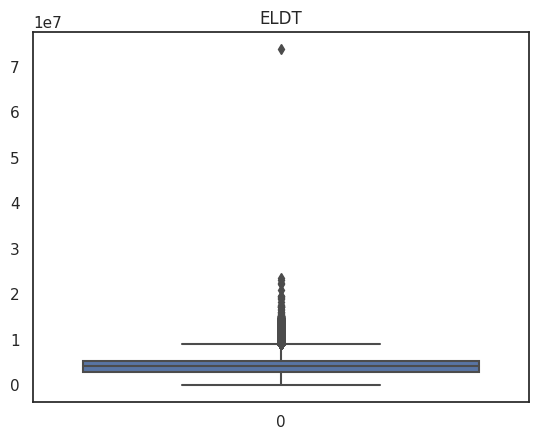

In [50]:
# Boxplot do ELDT

sns.boxplot(BIMTRA_df_adjusted['eldt'], showfliers=True)

plt.title('ELDT')

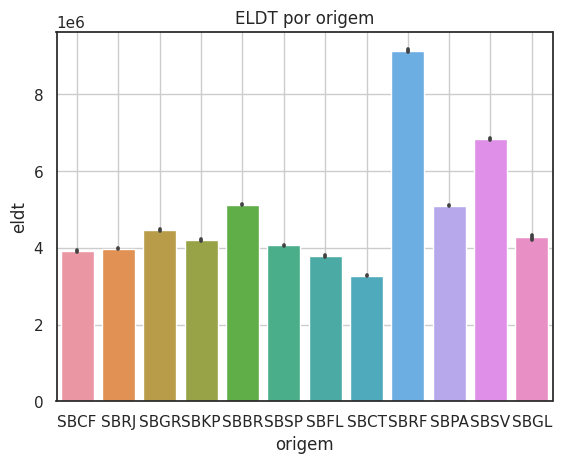

In [51]:
sns.barplot(x=BIMTRA_df_adjusted['origem'], y=BIMTRA_df_adjusted['eldt'])

plt.title('ELDT por origem')
plt.grid(True)

plt.show()

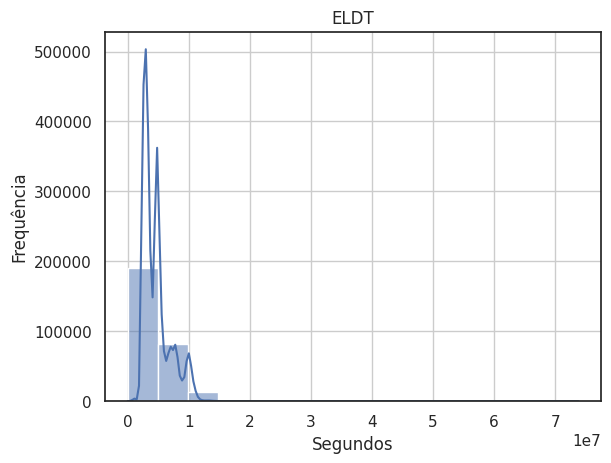

In [52]:
sns.histplot(BIMTRA_df_adjusted['eldt'], bins=15, kde = True)

plt.xlabel('Segundos')
plt.ylabel('Frequência')
plt.title('ELDT')
plt.grid(True)

plt.show()

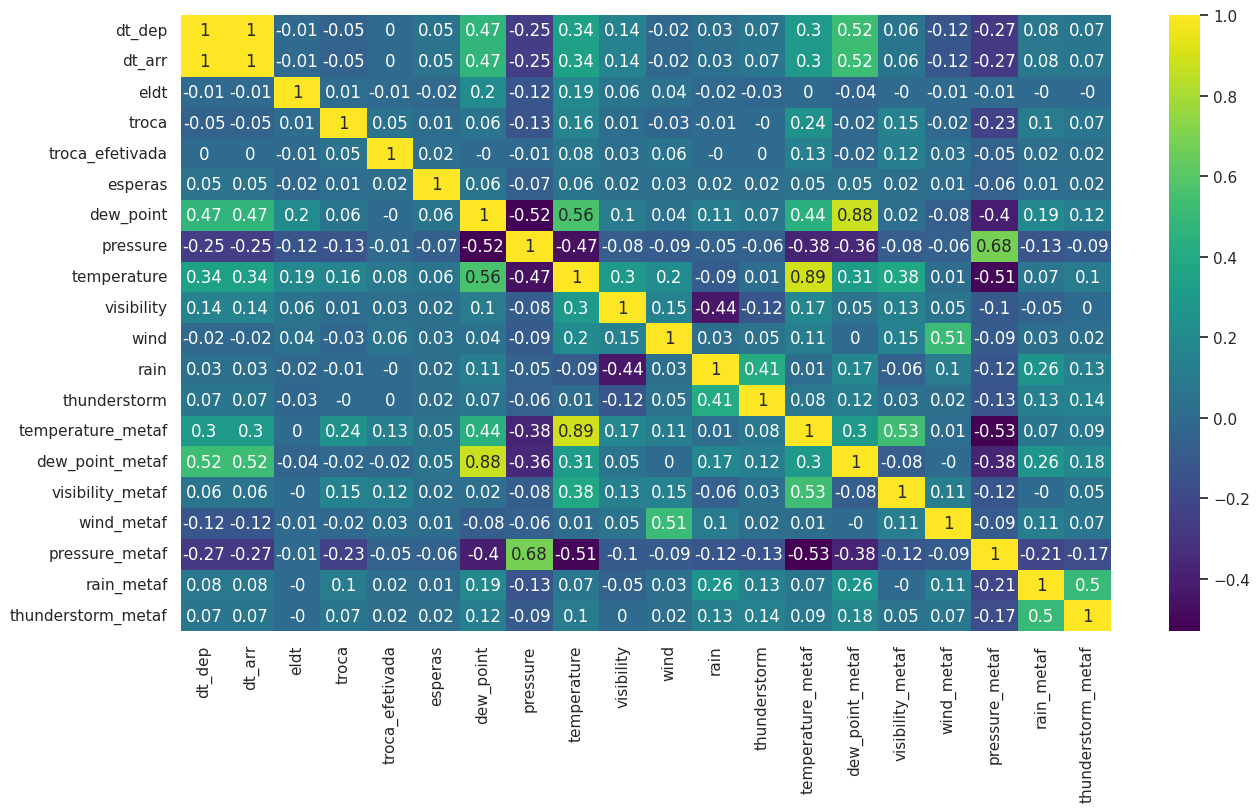

In [53]:
# Correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(BIMTRA_df_adjusted.corr().round(2), cmap='viridis',annot=True)
plt.show()


In [54]:
# Agrupar por origem e destino e calcular as estatísticas
impacto_aeroportos = BIMTRA_df_adjusted.groupby(['origem', 'destino']).agg({
    'flightid': 'count',              # Número total de voos
    'eldt': ['mean', 'min', 'max', 'std']  # Estatísticas de tempo de voo
}).reset_index()

# Renomear colunas para maior clareza
impacto_aeroportos.columns = ['Origem', 'Destino', 'Total_Voos', 'Tempo_Médio', 'Tempo_Mínimo', 'Tempo_Máximo', 'Desvio_Padrão']


display(impacto_aeroportos)

,Origem,Destino,Total_Voos,Tempo_Médio,Tempo_Mínimo,Tempo_Máximo,Desvio_Padrão
0,SBBR,SBCF,2992,3.298518e+06,1784000,6171000,284087.501994
1,SBBR,SBCT,1056,5.625054e+06,4999000,7148000,260428.622133
2,SBBR,SBFL,347,6.781703e+06,6020000,11724000,434887.250110
3,SBBR,SBGL,709,4.644795e+06,4043000,7165000,242529.296225
4,SBBR,SBGR,3530,4.671751e+06,3233000,15094000,374130.140507
...,...,...,...,...,...,...,...
133,SBSV,SBKP,1528,7.672034e+06,6563000,14055000,435601.958551
134,SBSV,SBPA,80,1.200070e+07,11010000,13671000,565408.498009
135,SBSV,SBRF,1671,3.815712e+06,3166000,9273000,447171.825250
136,SBSV,SBRJ,1850,6.789362e+06,4774000,16631000,511705.773859


# 3. Pré-processamento

In [55]:
BIMTRA_df_adjusted

,flightid,origem,destino,dt_dep,dt_arr,eldt,hora_ref,hora_tcp,troca,hora_tcr,...,rain,thunderstorm,hora_metaf,temperature_metaf,dew_point_metaf,visibility_metaf,wind_metaf,pressure_metaf,rain_metaf,thunderstorm_metaf
0,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000,5547000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,052050016538ab736a254313ef009a6b,SBRJ,SBCF,1654075204000,1654078210000,3006000,2022-06-01 09:00:00,2022-06-01 10:00:00,0.0,2022-06-01 09:00:00,...,0.0,0.0,2022-06-01 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,1654046445000,1654051465000,5020000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,15.0,14.0,1000.0,8.0,1018.0,0.0,0.0
3,2386fcd950814c8d343d93c4b51585d1,SBGR,SBPA,1654046039000,1654051301000,5262000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,15.0,14.0,1000.0,8.0,1018.0,0.0,0.0
4,f738e67220fcd688fed028a6389891e2,SBKP,SBPA,1654046798000,1654051882000,5084000,2022-06-01 01:00:00,2022-06-01 02:00:00,0.0,2022-06-01 01:00:00,...,0.0,0.0,2022-06-01 02:00:00,17.0,14.0,5000.0,14.0,1016.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286619,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,1683980059000,1683987623000,7564000,2023-05-13 12:00:00,2023-05-13 13:00:00,0.0,2023-05-13 12:00:00,...,0.0,0.0,2023-05-13 13:00:00,23.0,12.0,10000.0,4.0,1018.0,0.0,0.0
286620,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,1683970395000,1683975521000,5126000,2023-05-13 09:00:00,2023-05-13 10:00:00,0.0,2023-05-13 09:00:00,...,0.0,0.0,2023-05-13 10:00:00,17.0,12.0,10000.0,5.0,1016.0,0.0,0.0
286621,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,1683996833000,1684004424000,7591000,2023-05-13 16:00:00,2023-05-13 17:00:00,0.0,2023-05-13 16:00:00,...,0.0,0.0,2023-05-13 17:00:00,27.0,13.0,10000.0,2.0,1014.0,0.0,0.0
286622,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,1683955738000,1683964481000,8743000,2023-05-13 05:00:00,2023-05-13 06:00:00,0.0,2023-05-13 05:00:00,...,0.0,0.0,2023-05-13 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As colunas serão ordenadas. Colunas com alta correlação entre si podem ser descartadas. Além disso, apesar de manter aumentar os dados para o modelo analisar contribuirem com a diminuição do erro quadrático a primeiro momento, ao usar o modelo para prever os dados do kaggle foi observado que muitas colunas acabava tendo pior rendimento. Então, tentativa e erro pode ser um requisito?

In [283]:
BIMTRA_df_encoded = BIMTRA_df_adjusted.copy()

# Organizando a ordem das colunas
coluna_esperas = BIMTRA_df_encoded.pop('esperas')  # Remove a coluna 'C' do DataFrame
BIMTRA_df_encoded.insert(4, 'esperas', coluna_esperas)  # Insere a coluna 'C' na posição desejada (posição 1 neste caso)

l = list(BIMTRA_df_encoded.columns)
l.remove('eldt')
l.remove('flightid')
l.remove('dt_arr')
l.remove('hora_tcp')
l.remove('hora_tcr')
l.remove('hora_ref')
l.remove('hora_esperas')
l.remove('hora_metaf')
l.remove('temperature')
l.remove('dew_point')
#l.remove('wind')
#l.remove('weather')
#l.remove('pressure')
l.remove('temperature_metaf')
#l.remove('dew_point_metaf')
#l.remove('visibility_metaf')
#l.remove('wind_metaf')
l.remove('pressure_metaf')
l.remove('troca')
l.remove('troca_efetivada')
#l.remove('visibility')
#l.remove('esperas')
# l.remove('rain')
# l.remove('thunderstorm')
# l.remove('rain_metaf')
# l.remove('thunderstorm_metaf')
''' l.append('troca') '''
l.append('eldt')

BIMTRA_df_encoded = BIMTRA_df_encoded[l]

# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
BIMTRA_df_encoded['origem'] = BIMTRA_df_encoded['origem'].astype('category')
BIMTRA_df_encoded['destino'] = BIMTRA_df_encoded['destino'].astype('category')

''' BIMTRA_df_encoded.rename(columns={'troca_efetivada': 'troca'}, inplace=True) '''


BIMTRA_df_encoded

,origem,destino,dt_dep,esperas,pressure,visibility,wind,rain,thunderstorm,dew_point_metaf,visibility_metaf,wind_metaf,rain_metaf,thunderstorm_metaf,eldt
0,SBCF,SBFL,1654045238000,0.0,1018.0,10000.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,5547000
1,SBRJ,SBCF,1654075204000,0.0,1015.0,12000.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,3006000
2,SBGR,SBPA,1654046445000,0.0,1020.0,12000.0,3.0,0.0,0.0,14.0,1000.0,8.0,0.0,0.0,5020000
3,SBGR,SBPA,1654046039000,0.0,1020.0,12000.0,3.0,0.0,0.0,14.0,1000.0,8.0,0.0,0.0,5262000
4,SBKP,SBPA,1654046798000,0.0,1018.0,10000.0,14.0,0.0,0.0,14.0,5000.0,14.0,0.0,0.0,5084000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286619,SBBR,SBRF,1683980059000,0.0,1022.0,10000.0,4.0,0.0,0.0,12.0,10000.0,4.0,0.0,0.0,7564000
286620,SBBR,SBGR,1683970395000,0.0,1020.0,10000.0,0.0,0.0,0.0,12.0,10000.0,5.0,0.0,0.0,5126000
286621,SBCF,SBRF,1683996833000,0.0,1018.0,12000.0,6.0,0.0,0.0,13.0,10000.0,2.0,0.0,0.0,7591000
286622,SBSV,SBGR,1683955738000,0.0,1013.0,12000.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,8743000


In [284]:
# Create a boolean mask to identify rows with blank values
mask = BIMTRA_df_encoded.isnull().any(axis=1)

# Use the mask to filter the DataFrame
rows_with_blank_values = BIMTRA_df_encoded[mask]

# Display the rows with blank values
print(rows_with_blank_values)

df = BIMTRA_df_encoded.dropna()

       origem destino         dt_dep  esperas  pressure  visibility  wind  \
0        SBCF    SBFL  1654045238000      0.0    1018.0     10000.0   5.0   
1        SBRJ    SBCF  1654075204000      0.0    1015.0     12000.0   4.0   
7        SBCF    SBBR  1654082820000      0.0    1020.0     10000.0   3.0   
8        SBRJ    SBBR  1654082490000      0.0    1016.0      8000.0   2.0   
10       SBBR    SBGL  1654081726000      0.0    1020.0     10000.0   1.0   
...       ...     ...            ...      ...       ...         ...   ...   
286606   SBRF    SBSV  1683944548000      0.0    1014.0     12000.0   2.0   
286611   SBRF    SBGR  1683990991000      0.0    1014.0     12000.0   7.0   
286615   SBRF    SBGR  1683940138000      0.0    1015.0     12000.0   2.0   
286618   SBCT    SBGR  1683937233000      0.0    1022.0     12000.0   5.0   
286622   SBSV    SBGR  1683955738000      0.0    1013.0     12000.0   3.0   

        rain  thunderstorm  dew_point_metaf  visibility_metaf  wind_metaf  

# 4. Treinamento 

In [285]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(BIMTRA_df_encoded.copy().drop('eldt', axis=1), BIMTRA_df_encoded['eldt'], test_size=0.2)

Script para encontrar os melhores parâmetros para o XGBoost baseado no randomized search.

In [286]:
# reg = xg.XGBRegressor(objective= 'reg:squarederror', random_state=42, enable_categorical=True)

# # Busca de melhores parâmetros 
# params = {
#     "colsample_bytree": uniform(0.7, 0.3),
#     "gamma": uniform(0, 0.5),
#     "learning_rate": uniform(0.03, 0.3), # default 0.1 
#     "max_depth": randint(2, 6), # default 3
#     "n_estimators": randint(100, 150), # default 100
#     "subsample": uniform(0.6, 0.4)
# }

# search = RandomizedSearchCV(reg, param_distributions=params, random_state=42, n_iter=100, cv=3, verbose=2, n_jobs=1, return_train_score=True)

# search.fit(X_train, y_train)

# def report_best_scores(results, n_top=3):
#     for i in range(1, n_top + 1):
#         candidates = np.flatnonzero(results['rank_test_score'] == i)
#         for candidate in candidates:
#             print("Model with rank: {0}".format(i))
#             print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                   results['mean_test_score'][candidate],
#                   results['std_test_score'][candidate]))
#             print("Parameters: {0}".format(results['params'][candidate]))
#             print("")

# report_best_scores(search.cv_results_, 1)

In [287]:
# reg = xg.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7467983561008608, gamma=0.02904180608409973, learning_rate=0.28985284373248055, max_depth=5, n_estimators=139, subsample=0.8832290311184181, random_state=42, early_stopping_rounds=10, eval_set=[(X_test, y_test)], enable_categorical=True)

# Valores para esperas, pressao e visibilidade
# objective='reg:squarederror',
# colsample_bytree= 0.9043118281290726,
# gamma= 0.11875323564623497, 
# learning_rate= 0.15006686786160744, 
# max_depth= 5, 
# n_estimators= 148, 
# subsample= 0.6331565286773416,
# random_state = 42,
# enable_categorical=True,

# Valores para esperas, pressao, visibilidade e velocidade do vento
# objective='reg:squarederror',
# colsample_bytree= 0.935552788417904,
# gamma= 0.09983689107917987, 
# learning_rate= 0.18427033152408348, 
# max_depth= 5, 
# n_estimators= 102, 
# subsample= 0.9439761626945282,
# random_state = 42,
# enable_categorical=True,


# Valores para esperas, pressao (metar), temp(metaf), visibilidade e velocidade do vento metar e metaf
# objective='reg:squarederror',
# colsample_bytree= 0.7879632315094193,
# gamma= 0.16433227268495798, 
# learning_rate= 0.2317555368231115, 
# max_depth= 5, 
# n_estimators= 122, 
# subsample= 0.9125184201884811,
# random_state = 42,
# enable_categorical=True,


reg = xg.XGBRegressor(
    objective='reg:squarederror',

    enable_categorical=True,
)

reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## 4.1 Performance do modelo

In [288]:
print("Performance do modelo nos dados de treino: ", str(round(reg.score(X_train, y_train) * 100, 2))+"%")
print("Performance do modelo nos dados de teste: ", str(round(reg.score(X_test, y_test) * 100, 2))+"%")

Performance do modelo nos dados de treino:  96.88%
Performance do modelo nos dados de teste:  96.84%


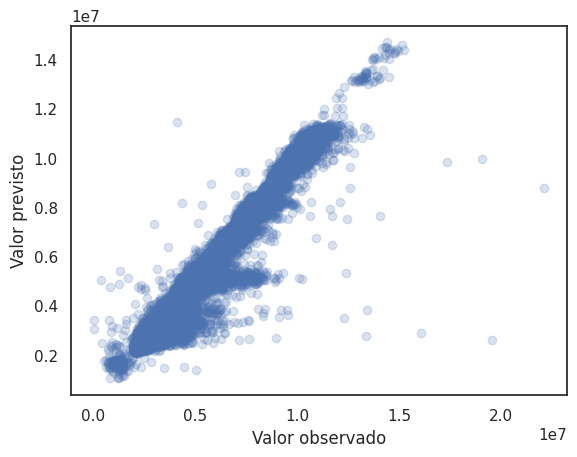

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

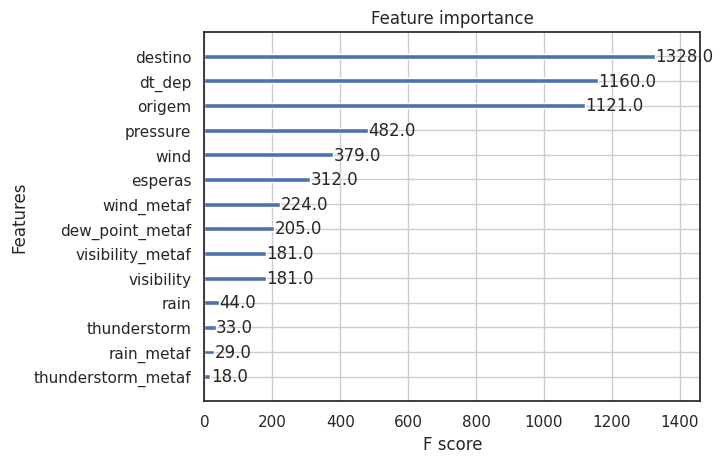

In [289]:
# Previsão
y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel('Valor observado')
plt.ylabel('Valor previsto')
plt.show()

xg.plot_importance(reg)

# fig = px.scatter(x=y_test, y=y_pred)
# fig.update_xaxes(title="Valor observado")
# fig.update_yaxes(title="Valor previsto")

# # Add a title
# fig.update_layout(title="Valor observado vs. Valor previsto")


In [290]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Erro Quadrático Médio (MSE): ", mean_squared_error(y_test, y_pred))
print("Erro Absoluto Médio (MAE): ", mean_absolute_error(y_test, y_pred))
print("Raiz do Erro Quadrático Médio (RMSE) : ", np.sqrt(mean_squared_error(y_test, y_pred)))

print("R2: ", r2_score(y_test, y_pred))

Erro Quadrático Médio (MSE):  156355856221.6417
Erro Absoluto Médio (MAE):  229794.4757468382
Raiz do Erro Quadrático Médio (RMSE) :  395418.5835562634
R2:  0.9683575293543556


# 5. Submissão

In [291]:
# Csv de teste do Kaggle
idsc_test = pd.read_csv('idsc_test.csv')
idsc_test

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6f6d576aafbd90e308a848a060395e9a,SBPA,SBGR,2023-05-19 22:02:03.000,2023-05-19 22:00:00.000,MULTIPOINT ((-0.8891070333352145 -0.5128856751...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 21:00:00.000,0,SBGR,...,METAF SBGR 192300Z 11006KT 9000 FEW019 ...,SBGR,2023-05-19 22:00:00.000,METAR SBGR 192200Z 14003KT CAVOK 16/13 Q1021=,SBGR,2023-05-19 23:00:00.000,0,SBGR,NaN,NaN
96,20055ed6ecea5e916923081fc3b049f7,SBCF,SBKP,2023-05-31 19:54:04.000,2023-05-31 19:00:00.000,MULTIPOINT ((-0.8887839089364267 -0.5156303040...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 18:00:00.000,0,SBKP,...,METAF SBKP 312000Z 23006KT 9999 OVC022 ...,SBKP,2023-05-31 19:00:00.000,METAR SBKP 311900Z 24005KT 5000 2000S -RA BR B...,SBKP,2023-05-31 20:00:00.000,0,SBKP,2023-05-31 19:00:00.000,SBKP
97,c5e4e8d78906ae2b3218847cc9f045d9,SBSP,SBRJ,2023-05-20 15:16:05.000,2023-05-20 15:00:00.000,MULTIPOINT ((-0.8916331377478003 -0.5089690765...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-20 14:00:00.000,0,SBRJ,...,METAF SBRJ 201600Z 10003KT 9999 FEW033 ...,SBRJ,2023-05-20 15:00:00.000,METAR SBRJ 201500Z 34003KT 250V040 CAVOK 23/16...,SBRJ,2023-05-20 16:00:00.000,0,SBRJ,NaN,NaN
98,878ad3e9104c78f2945f6194c2d883ce,SBBR,SBSP,2023-05-31 11:31:02.000,2023-05-31 11:00:00.000,MULTIPOINT ((-0.8987280459174578 -0.5209708603...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 10:00:00.000,0,SBSP,...,METAF SBSP 311200Z 07006KT 6000 - RA OVC026 ...,SBSP,2023-05-31 11:00:00.000,METAR SBSP 311100Z 08006KT 020V120 4000 -RA BR...,SBSP,2023-05-31 12:00:00.000,0,SBSP,NaN,NaN


Tratar dados cabeceiras

In [292]:
idsc_test.rename(columns={'aero_tcr': 'troca_efetivada'}, inplace=True)
idsc_test['troca_efetivada'] = idsc_test['troca_efetivada'].apply(lambda x: 0 if pd.isna(x) else 1)
idsc_test


,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,troca_efetivada
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,0
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,0
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,0
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,0
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6f6d576aafbd90e308a848a060395e9a,SBPA,SBGR,2023-05-19 22:02:03.000,2023-05-19 22:00:00.000,MULTIPOINT ((-0.8891070333352145 -0.5128856751...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 21:00:00.000,0,SBGR,...,METAF SBGR 192300Z 11006KT 9000 FEW019 ...,SBGR,2023-05-19 22:00:00.000,METAR SBGR 192200Z 14003KT CAVOK 16/13 Q1021=,SBGR,2023-05-19 23:00:00.000,0,SBGR,NaN,0
96,20055ed6ecea5e916923081fc3b049f7,SBCF,SBKP,2023-05-31 19:54:04.000,2023-05-31 19:00:00.000,MULTIPOINT ((-0.8887839089364267 -0.5156303040...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 18:00:00.000,0,SBKP,...,METAF SBKP 312000Z 23006KT 9999 OVC022 ...,SBKP,2023-05-31 19:00:00.000,METAR SBKP 311900Z 24005KT 5000 2000S -RA BR B...,SBKP,2023-05-31 20:00:00.000,0,SBKP,2023-05-31 19:00:00.000,1
97,c5e4e8d78906ae2b3218847cc9f045d9,SBSP,SBRJ,2023-05-20 15:16:05.000,2023-05-20 15:00:00.000,MULTIPOINT ((-0.8916331377478003 -0.5089690765...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-20 14:00:00.000,0,SBRJ,...,METAF SBRJ 201600Z 10003KT 9999 FEW033 ...,SBRJ,2023-05-20 15:00:00.000,METAR SBRJ 201500Z 34003KT 250V040 CAVOK 23/16...,SBRJ,2023-05-20 16:00:00.000,0,SBRJ,NaN,0
98,878ad3e9104c78f2945f6194c2d883ce,SBBR,SBSP,2023-05-31 11:31:02.000,2023-05-31 11:00:00.000,MULTIPOINT ((-0.8987280459174578 -0.5209708603...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 10:00:00.000,0,SBSP,...,METAF SBSP 311200Z 07006KT 6000 - RA OVC026 ...,SBSP,2023-05-31 11:00:00.000,METAR SBSP 311100Z 08006KT 020V120 4000 -RA BR...,SBSP,2023-05-31 12:00:00.000,0,SBSP,NaN,0


Tratar dados metar

In [293]:
metar_columns_sub = get_all_metar_data(idsc_test['metar'])

metar_columns_sub

-----------------------------------------------------------------------
METAR:  METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q1019=
-----------------------------------------------------------------------
Wed Aug 30 11:00:00 2023
-----------------------------------------------------------------------
METAR:  METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 BKN050 19/17 Q1019=
-----------------------------------------------------------------------
Tue Sep 19 08:00:00 2023
-----------------------------------------------------------------------
METAR:  METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=
-----------------------------------------------------------------------
Fri Sep 22 11:00:00 2023
-----------------------------------------------------------------------
METAR:  METAR SBSP 291600Z 12010KT 090V160 9999 SCT015 SCT019 19/14 Q1023=
-----------------------------------------------------------------------
Tue Aug 29 16:00:00 2023
-------------------------------------------------------------

,aeroporto,report_type,time,temperature,dew_point,visibility,wind,visual_range,pressure,weather,sky
0,SBSV,"routine report, cycle 11 (automatic report)",Wed Aug 30 11:00:00 2023,28.0 C,21.0 C,greater than 10000 meters,ESE at 9 knots,NaN,1019.0 mb,,a few clouds at 2300 feet
1,SBRJ,"routine report, cycle 8 (automatic report)",Tue Sep 19 08:00:00 2023,19.0 C,17.0 C,greater than 10000 meters,NNE at 4 knots,NaN,1019.0 mb,,a few clouds at 1000 feet\n scattered clou...
2,SBGR,"routine report, cycle 11 (automatic report)",Fri Sep 22 11:00:00 2023,13.0 C,12.0 C,10000 meters,ENE at 6 knots,NaN,1022.0 mb,,
3,SBSP,"routine report, cycle 16 (automatic report)",Tue Aug 29 16:00:00 2023,19.0 C,14.0 C,greater than 10000 meters,E to SSE at 10 knots,NaN,1023.0 mb,,scattered clouds at 1500 feet\n scattered ...
4,SBKP,"routine report, cycle 22 (automatic report)",Mon Sep 25 22:00:00 2023,23.0 C,13.0 C,10000 meters,E at 4 knots,NaN,1020.0 mb,,
...,...,...,...,...,...,...,...,...,...,...,...
95,SBGR,"routine report, cycle 22 (automatic report)",Tue Sep 19 22:00:00 2023,16.0 C,13.0 C,10000 meters,SE at 3 knots,NaN,1021.0 mb,,
96,SBKP,"routine report, cycle 19 (automatic report)",Thu Aug 31 19:00:00 2023,18.0 C,17.0 C,5000 meters; 2000 meters to S,WSW at 5 knots,NaN,1020.0 mb,light rain; mist,broken clouds at 700 feet\n overcast at 30...
97,SBRJ,"routine report, cycle 15 (automatic report)",Wed Sep 20 15:00:00 2023,23.0 C,16.0 C,10000 meters,WSW to NE at 3 knots,NaN,1019.0 mb,,
98,SBSP,"routine report, cycle 11 (automatic report)",Thu Aug 31 11:00:00 2023,15.0 C,15.0 C,4000 meters,NNE to ESE at 6 knots,NaN,1022.0 mb,light rain; mist,broken clouds at 500 feet\n overcast at 70...


In [294]:
metar_to_merge_sub = get_columns_metar(metar_columns_sub)

metar_to_merge_sub

,temperature,dew_point,visibility,wind,pressure,rain,thunderstorm
0,28.0,21.0,12000,9,1019.0,0,0
1,19.0,17.0,12000,4,1019.0,0,0
2,13.0,12.0,10000,6,1022.0,0,0
3,19.0,14.0,12000,10,1023.0,0,0
4,23.0,13.0,10000,4,1020.0,0,0
...,...,...,...,...,...,...,...
95,16.0,13.0,10000,3,1021.0,0,0
96,18.0,17.0,5000,5,1020.0,1,0
97,23.0,16.0,10000,3,1019.0,0,0
98,15.0,15.0,4000,6,1022.0,1,0


In [295]:
idsc_test = pd.concat([idsc_test, metar_to_merge_sub], axis=1)

Tratar dados metaf

In [296]:
idsc_test['metaf'] = idsc_test['metaf'].str.replace('METAF', 'METAR')


metaf_columns_sub = get_all_metar_data(idsc_test['metaf'])

metaf_columns_sub

-----------------------------------------------------------------------
METAR:  METAR SBRJ 190900Z  33004KT 9999       BKN033   17/12 Q1020=

-----------------------------------------------------------------------
Tue Sep 19 09:00:00 2023
-----------------------------------------------------------------------
METAR:  METAR SBGR 221200Z 04003KT CAVOK 19/09 Q1021=

-----------------------------------------------------------------------
Fri Sep 22 12:00:00 2023
-----------------------------------------------------------------------
METAR:  METAR SBSP 291700Z  15010KT 9999       OVC033   18/14 Q1019=

-----------------------------------------------------------------------
Tue Aug 29 17:00:00 2023
-----------------------------------------------------------------------
METAR:  METAR SBKP 252300Z 08008KT CAVOK 21/12 Q1019=

-----------------------------------------------------------------------
Mon Sep 25 23:00:00 2023
-----------------------------------------------------------------------
ME

,aeroporto,report_type,time,temperature,dew_point,visibility,wind,visual_range,pressure,weather,sky
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SBRJ,"routine report, cycle 9 (automatic report)",Tue Sep 19 09:00:00 2023,17.0 C,12.0 C,greater than 10000 meters,NNW at 4 knots,NaN,1020.0 mb,,broken clouds at 3300 feet
2,SBGR,"routine report, cycle 12 (automatic report)",Fri Sep 22 12:00:00 2023,19.0 C,9.0 C,10000 meters,NE at 3 knots,NaN,1021.0 mb,,
3,SBSP,"routine report, cycle 17 (automatic report)",Tue Aug 29 17:00:00 2023,18.0 C,14.0 C,greater than 10000 meters,SSE at 10 knots,NaN,1019.0 mb,,overcast at 3300 feet
4,SBKP,"routine report, cycle 23 (automatic report)",Mon Sep 25 23:00:00 2023,21.0 C,12.0 C,10000 meters,E at 8 knots,NaN,1019.0 mb,,
...,...,...,...,...,...,...,...,...,...,...,...
95,SBGR,"routine report, cycle 23 (automatic report)",Tue Sep 19 23:00:00 2023,16.0 C,12.0 C,9000 meters,ESE at 6 knots,NaN,1019.0 mb,,a few clouds at 1900 feet
96,SBKP,"routine report, cycle 20 (automatic report)",Thu Aug 31 20:00:00 2023,21.0 C,16.0 C,greater than 10000 meters,SW at 6 knots,NaN,1018.0 mb,,overcast at 2200 feet
97,SBRJ,"routine report, cycle 16 (automatic report)",Wed Sep 20 16:00:00 2023,25.0 C,12.0 C,greater than 10000 meters,E at 3 knots,NaN,1018.0 mb,,a few clouds at 3300 feet
98,SBSP,"routine report, cycle 12 (automatic report)",Thu Aug 31 12:00:00 2023,17.0 C,14.0 C,6000 meters,ENE at 6 knots,NaN,1021.0 mb,light; rain,overcast at 2600 feet


In [297]:
metaf_to_merge_sub = metaf_columns_sub.copy()

metaf_to_merge_sub = get_columns_metar(metaf_to_merge_sub)
metaf_to_merge_sub.columns = change_columns_names_metaf(metaf_to_merge_sub)
idsc_test = pd.concat([idsc_test, metaf_to_merge_sub], axis=1)

metaf_to_merge_sub

,temperature_metaf,dew_point_metaf,visibility_metaf,wind_metaf,pressure_metaf,rain_metaf,thunderstorm_metaf
0,NaN,NaN,NaN,NaN,NaN,0,0
1,17.0,12.0,12000.0,4.0,1020.0,0,0
2,19.0,9.0,10000.0,3.0,1021.0,0,0
3,18.0,14.0,12000.0,10.0,1019.0,0,0
4,21.0,12.0,10000.0,8.0,1019.0,0,0
...,...,...,...,...,...,...,...
95,16.0,12.0,9000.0,6.0,1019.0,0,0
96,21.0,16.0,12000.0,6.0,1018.0,0,0
97,25.0,12.0,12000.0,3.0,1018.0,0,0
98,17.0,14.0,6000.0,6.0,1021.0,2,0


In [298]:
idsc_test

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,pressure,rain,thunderstorm,temperature_metaf,dew_point_metaf,visibility_metaf,wind_metaf,pressure_metaf,rain_metaf,thunderstorm_metaf
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,1019.0,0,0,NaN,NaN,NaN,NaN,NaN,0,0
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,1019.0,0,0,17.0,12.0,12000.0,4.0,1020.0,0,0
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,1022.0,0,0,19.0,9.0,10000.0,3.0,1021.0,0,0
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,1023.0,0,0,18.0,14.0,12000.0,10.0,1019.0,0,0
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,1020.0,0,0,21.0,12.0,10000.0,8.0,1019.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6f6d576aafbd90e308a848a060395e9a,SBPA,SBGR,2023-05-19 22:02:03.000,2023-05-19 22:00:00.000,MULTIPOINT ((-0.8891070333352145 -0.5128856751...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 21:00:00.000,0,SBGR,...,1021.0,0,0,16.0,12.0,9000.0,6.0,1019.0,0,0
96,20055ed6ecea5e916923081fc3b049f7,SBCF,SBKP,2023-05-31 19:54:04.000,2023-05-31 19:00:00.000,MULTIPOINT ((-0.8887839089364267 -0.5156303040...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 18:00:00.000,0,SBKP,...,1020.0,1,0,21.0,16.0,12000.0,6.0,1018.0,0,0
97,c5e4e8d78906ae2b3218847cc9f045d9,SBSP,SBRJ,2023-05-20 15:16:05.000,2023-05-20 15:00:00.000,MULTIPOINT ((-0.8916331377478003 -0.5089690765...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-20 14:00:00.000,0,SBRJ,...,1019.0,0,0,25.0,12.0,12000.0,3.0,1018.0,0,0
98,878ad3e9104c78f2945f6194c2d883ce,SBBR,SBSP,2023-05-31 11:31:02.000,2023-05-31 11:00:00.000,MULTIPOINT ((-0.8987280459174578 -0.5209708603...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-31 10:00:00.000,0,SBSP,...,1022.0,1,0,17.0,14.0,6000.0,6.0,1021.0,2,0


In [299]:
print(l)

['origem', 'destino', 'dt_dep', 'esperas', 'pressure', 'visibility', 'wind', 'rain', 'thunderstorm', 'dew_point_metaf', 'visibility_metaf', 'wind_metaf', 'rain_metaf', 'thunderstorm_metaf', 'eldt']


In [300]:
idsc_test_encoded = idsc_test.copy()

# Organizando as colunas
colunas_sub = l.copy()
colunas_sub.remove('eldt')
idsc_test_encoded = idsc_test_encoded[colunas_sub]

# Converte data e hora para o tipo milissegundos desde 1970
datetime_to_int64(idsc_test_encoded, 'dt_dep')

# Converte variáveis categoricas para o tipo "category" (Requisito pro XGBoost funcionar)
idsc_test_encoded['origem'] = idsc_test_encoded['origem'].astype('category')
idsc_test_encoded['destino'] = idsc_test_encoded['destino'].astype('category')

idsc_test_encoded

,origem,destino,dt_dep,esperas,pressure,visibility,wind,rain,thunderstorm,dew_point_metaf,visibility_metaf,wind_metaf,rain_metaf,thunderstorm_metaf
0,SBKP,SBSV,1.685447e+12,0,1019.0,12000,9,0,0,NaN,NaN,NaN,0,0
1,SBFL,SBRJ,1.684485e+12,0,1019.0,12000,4,0,0,12.0,12000.0,4.0,0,0
2,SBCF,SBGR,1.684756e+12,0,1022.0,10000,6,0,0,9.0,10000.0,3.0,0,0
3,SBFL,SBSP,1.685376e+12,2,1023.0,12000,10,0,0,14.0,12000.0,10.0,0,0
4,SBCF,SBKP,1.685053e+12,0,1020.0,10000,4,0,0,12.0,10000.0,8.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SBPA,SBGR,1.684534e+12,0,1021.0,10000,3,0,0,12.0,9000.0,6.0,0,0
96,SBCF,SBKP,1.685563e+12,0,1020.0,5000,5,1,0,16.0,12000.0,6.0,0,0
97,SBSP,SBRJ,1.684596e+12,0,1019.0,10000,3,0,0,12.0,12000.0,3.0,0,0
98,SBBR,SBSP,1.685533e+12,0,1022.0,4000,6,1,0,14.0,6000.0,6.0,2,0


In [301]:
# Prediz os valores
y_pred = reg.predict(idsc_test_encoded)
data_in_seconds = y_pred / 1000.0

# Criar um DataFrame com a coluna de dados em segundos
y_pred = pd.DataFrame(data_in_seconds)

y_pred

,0
0,7052.561035
1,4096.456055
2,3302.935303
3,3136.807861
4,3271.897705
...,...
95,5110.465332
96,3346.028809
97,2494.248779
98,4919.497070


In [302]:
sumbission = pd.DataFrame()
sumbission['ID'] = idsc_test['flightid']
sumbission['solution'] = y_pred

sumbission.to_csv('submission.csv', index=False)

In [303]:
sumbission

,ID,solution
0,7945735584a3297121c4f5ae0de8ecd1,7052.561035
1,85cb958e8b9d583575cd9cb93e389226,4096.456055
2,2d4e8cd3947525a12ff16af520beefb9,3302.935303
3,24cf317a1494a016a018d9f5cd183639,3136.807861
4,370babaf32dc82a6a64bf5b71a3434ed,3271.897705
...,...,...
95,6f6d576aafbd90e308a848a060395e9a,5110.465332
96,20055ed6ecea5e916923081fc3b049f7,3346.028809
97,c5e4e8d78906ae2b3218847cc9f045d9,2494.248779
98,878ad3e9104c78f2945f6194c2d883ce,4919.497070


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4ef28bfa-f18c-417e-93b5-8e27cf9bc92e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>